# Setup Notebook

In [1]:
# When working in AI LRZ
%cd ~/cma/CMA_Fairness_v2

/dss/dsshome1/0C/ra93lal2/cma/CMA_Fairness_v2


/dss/dsshome1/0C/ra93lal2/.local/share/virtualenvs/CMA_Fairness_v2-3j10GkSs/lib/python3.10/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/dss/dsshome1/0C/ra93lal2/.local/share/virtualenvs/CMA_Fairness_v2-3j10GkSs/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [14]:
%run analysis_setup_cp.ipynb

/dss/dsshome1/0C/ra93lal2/cma/CMA_Fairness_v2
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The data has N = 80 rows and N = 12 columns.


## Prepare Data


In [ ]:
# Filter out a single configuration to keep data manageable
#df_agg = df_agg_full[
#  (df_agg_full["sett_eval_fairness_grouping"] == "nationality-all") #&
#  #(df_agg_full["sett_eval_exclude_subgroups"] == "keep-in-eval") &
#  #(df_agg_full["sett_eval_on_subset"] == "full")
#][
#  # Remove eval columns
#  cols_non_eval + cols_performance + cols_fairness
#].reset_index(drop = True)
#
#df_agg.shape

In [15]:
import pandas as pd
from pathlib import Path

RUN_TO_ANALYSE = "4"
CP_DIR = Path("output") / "runs" / str(RUN_TO_ANALYSE)

df_agg = pd.read_csv(CP_DIR / "combined_cp_metrics.csv")

In [16]:
df_agg.head()

,universe_id,universe_model,universe_exclude_features,universe_exclude_subgroups,universe_scale,q_hat,coverage,avg_size,cov_frau1,cov_nongerman,cov_nongerman_male,cov_nongerman_female
0,178e4745600648bf3470ed27ba046cb4,rf,nationality-sex,keep-all,scale,0.650000,0.913544,1.141367,0.912279,0.907090,0.922003,0.882414
1,240998e0db90607c9ab50f364189b362,rf,nationality,keep-all,do-not-scale,0.660000,0.914926,1.149850,0.914193,0.907427,0.919661,0.887183
2,de6d55feceb94a23585f9ab70ec712e7,rf,sex,keep-all,do-not-scale,0.660000,0.915795,1.149125,0.915352,0.910739,0.925606,0.886140
3,0b098db4ebd5481f9b74bc56cd4471cc,gbm,none,drop-non-german,do-not-scale,0.664399,0.912095,1.117178,0.911390,0.910795,0.926596,0.884650
4,ad48488da884420acb8a216603922a86,gbm,nationality-sex,drop-non-german,scale,0.664448,0.911749,1.116620,0.912252,0.911245,0.926596,0.885842


In [17]:
df_agg.shape

(80, 12)

In [18]:
main_cp_metric = "avg_size"

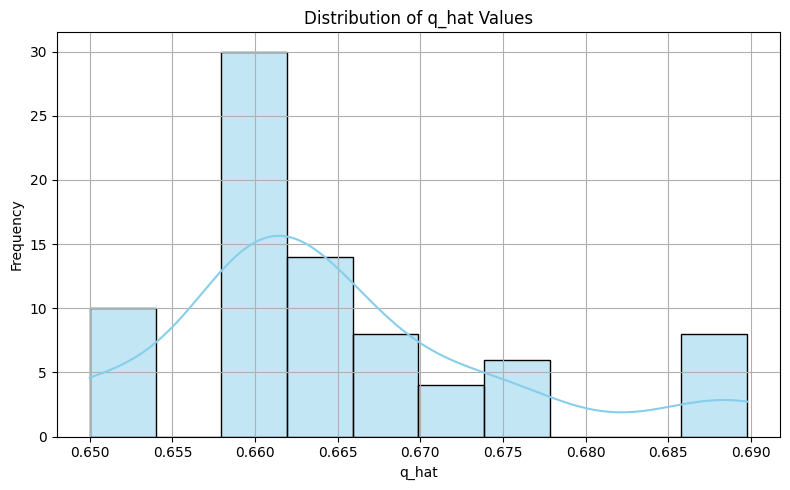

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot distribution of q_hat
plt.figure(figsize=(8, 5))
sns.histplot(df_agg["q_hat"], bins=10, kde=True, color="skyblue")
plt.title("Distribution of q_hat Values")
plt.xlabel("q_hat")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate Variable Importance

## Use a Lasso Regression to estimate Importance of Settings

In [20]:
X = df_agg[["universe_model", "universe_exclude_features", "universe_exclude_subgroups", "universe_scale"]]
y = df_agg[main_cp_metric]

In [21]:
X.head()

,universe_model,universe_exclude_features,universe_exclude_subgroups,universe_scale
0,rf,nationality-sex,keep-all,scale
1,rf,nationality,keep-all,do-not-scale
2,rf,sex,keep-all,do-not-scale
3,gbm,none,drop-non-german,do-not-scale
4,gbm,nationality-sex,drop-non-german,scale


In [22]:
X.shape

(80, 4)

In [23]:
y.shape

(80,)

### Main Effects of Settings Only (i.e. no interactions)

In [24]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LassoCV

# Do preprocessing in a separate pipeline from model fitting
# (for eli5 to work)
preprocessor = make_pipeline(
    OneHotEncoder(), # Converts categorical features to one-hot encoded format
).fit(X) # Fit the preprocessing pipeline to the input data X
X_processed = preprocessor.transform(X) # This creates a numeric matrix suitable for modeling

# Fit a Lasso regression model with cross-validation to the processed data
lasso_reg = LassoCV(cv=5, random_state=0).fit(X_processed, y)

# Check whether it's predictive at all
lasso_reg.score(X_processed, y) # Evaluate the model's R^2 score on the training data


0.6234064726606631

R² = 1.0: Perfect predictions

R² = 0.0: Model does no better than predicting the mean

R² < 0.0: Model is worse than just predicting the mean

Weights of importance:

In [25]:
# Visualize the importance of each feature in trained lasso_reg model
import eli5
eli5.show_weights(lasso_reg, top=-1, feature_names = preprocessor.get_feature_names_out())


Weight?,Feature
+1.129,<BIAS>
+0.031,universe_scale_do-not-scale
+0.017,universe_model_penalized_logreg
+0.017,universe_model_logreg
-0.000,universe_scale_scale
-0.011,universe_model_elasticnet
-0.024,universe_model_gbm


### Including Interactions

In [26]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LassoCV

# Do preprocessing w/o a pipeline for eli5 to work
preprocessor = make_pipeline(
    OneHotEncoder(),
    PolynomialFeatures(degree=2),
).fit(X)
X_processed = preprocessor.transform(X)

lasso_reg = LassoCV(cv=5, random_state=0).fit(X_processed, y)

# Check whether it's predictive at all
lasso_reg.score(X_processed, y) # Evaluate the model's R^2 score on the training data


0.9956968409760666

Weights of importance:

In [27]:
import eli5
eli5.show_weights(lasso_reg, top=-1, feature_names = preprocessor.get_feature_names_out())


Weight?,Feature
+1.126,<BIAS>
+0.070,universe_model_logreg universe_scale_do-not-scale
+0.070,universe_model_penalized_logreg universe_scale_do-not-scale
+0.008,universe_model_rf universe_scale_scale
+0.008,universe_model_rf universe_exclude_subgroups_keep-all
+0.007,universe_scale_do-not-scale
+0.005,universe_model_rf^2
+0.003,universe_exclude_subgroups_drop-non-german universe_scale_do-not-scale
+0.003,universe_model_penalized_logreg universe_exclude_subgroups_drop-non-german
+0.003,universe_model_logreg universe_exclude_subgroups_drop-non-german


## Use a functinoal ANOVA (fANOVA) to Analyze Setting Importance

Based on the following paper:

Hutter, F., Hoos, H., & Leyton-Brown, K. (2014). An Efficient Approach for Assessing Hyperparameter Importance. Proceedings of the 31st International Conference on Machine Learning, 754–762. https://proceedings.mlr.press/v32/hutter14.html


In [29]:
from fairness_multiverse.analysis import MultiverseFanova

m_fanova = MultiverseFanova(features = df_agg[["universe_model", "universe_exclude_features", "universe_exclude_subgroups", "universe_scale"]], outcome = df_agg[main_cp_metric])


In [30]:
m_fanova.quantify_individual_importance()

,individual importance,total importance,individual std,total std
universe_exclude_features,0.020256,0.020256,0.029278,0.029278
universe_exclude_subgroups,0.005144,0.005144,0.007557,0.007557
universe_model,0.298779,0.298779,0.106537,0.106537
universe_scale,0.245218,0.245218,0.104788,0.104788


In [31]:
m_fanova.quantify_importance(save_to = "fanova_importance_interactions-overall_alpha_2.csv")

,level_0,level_1,level_2,level_3,individual importance,total importance,individual std,total std
2,universe_model,NaN,NaN,NaN,0.298779,0.298779,0.106537,1.065375e-01
3,universe_scale,NaN,NaN,NaN,0.245218,0.245218,0.104788,1.047880e-01
9,universe_model,universe_scale,NaN,NaN,0.243788,0.787785,0.095192,1.613585e-01
13,universe_exclude_subgroups,universe_model,universe_scale,NaN,0.035341,0.867026,0.039510,1.302157e-01
5,universe_exclude_features,universe_model,NaN,NaN,0.034354,0.353390,0.038851,1.238464e-01
7,universe_exclude_subgroups,universe_model,NaN,NaN,0.027422,0.331345,0.037571,8.956090e-02
12,universe_exclude_features,universe_model,universe_scale,NaN,0.025868,0.882380,0.030373,1.093596e-01
0,universe_exclude_features,NaN,NaN,NaN,0.020256,0.020256,0.029278,2.927822e-02
10,universe_exclude_features,universe_exclude_subgroups,universe_model,NaN,0.014285,0.407413,0.016279,1.106103e-01
6,universe_exclude_features,universe_scale,NaN,NaN,0.014117,0.279591,0.017471,9.179641e-02


In [32]:
# Format

cols_to_format = [
    "individual importance",
    "total importance",
    "individual std",
    "total std"
]

fanova_interactions = m_fanova.quantify_importance()
fanova_interactions[cols_to_format] = fanova_interactions[cols_to_format].applymap(lambda x: f"{x:.4f}")
fanova_interactions

,level_0,level_1,level_2,level_3,individual importance,total importance,individual std,total std
2,universe_model,NaN,NaN,NaN,0.2988,0.2988,0.1065,0.1065
3,universe_scale,NaN,NaN,NaN,0.2452,0.2452,0.1048,0.1048
9,universe_model,universe_scale,NaN,NaN,0.2438,0.7878,0.0952,0.1614
13,universe_exclude_subgroups,universe_model,universe_scale,NaN,0.0353,0.8670,0.0395,0.1302
5,universe_exclude_features,universe_model,NaN,NaN,0.0344,0.3534,0.0389,0.1238
7,universe_exclude_subgroups,universe_model,NaN,NaN,0.0274,0.3313,0.0376,0.0896
12,universe_exclude_features,universe_model,universe_scale,NaN,0.0259,0.8824,0.0304,0.1094
0,universe_exclude_features,NaN,NaN,NaN,0.0203,0.0203,0.0293,0.0293
10,universe_exclude_features,universe_exclude_subgroups,universe_model,NaN,0.0143,0.4074,0.0163,0.1106
6,universe_exclude_features,universe_scale,NaN,NaN,0.0141,0.2796,0.0175,0.0918


In [33]:
best_p_margs = m_fanova.fanova.get_most_important_pairwise_marginals(n=5)
print(best_p_margs)

OrderedDict([(('universe_model', 'universe_scale'), 0.24378842826771963), (('universe_exclude_features', 'universe_model'), 0.0343541086427665), (('universe_exclude_subgroups', 'universe_model'), 0.02742221529856812), (('universe_exclude_features', 'universe_scale'), 0.014117240103096748), (('universe_exclude_subgroups', 'universe_scale'), 0.011333912921529805)])


In [34]:
# Directory that will contain outputs from analysis

from pathlib import Path

ANALYSIS_OUTPUT_DIR = Path(".") / "analyses"
ANALYSIS_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

In [35]:
from fanova import visualizer

vis = visualizer.Visualizer(m_fanova.fanova, m_fanova.configuration_space, directory = str(ANALYSIS_OUTPUT_DIR))

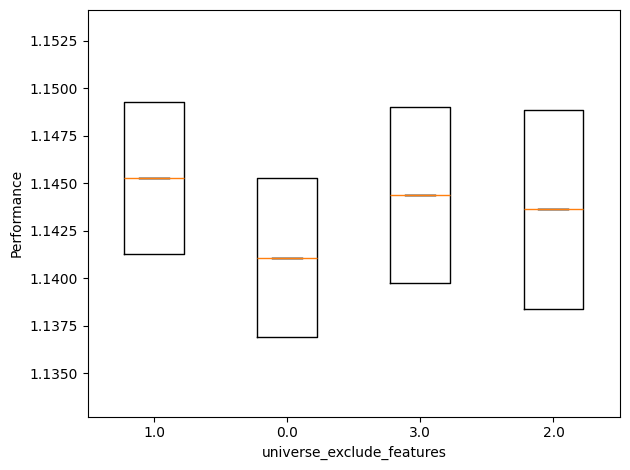

In [36]:
vis.plot_marginal(0)

/dss/dsshome1/0C/ra93lal2/.local/share/virtualenvs/CMA_Fairness_v2-3j10GkSs/lib/python3.10/site-packages/fanova/visualizer.py:123: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  grid_fanova = np.array(grid_fanova)
INFO:fanova.visualizer.Visualizer:creating analyses/interactive_plots


<module 'matplotlib.pyplot' from '/dss/dsshome1/0C/ra93lal2/.local/share/virtualenvs/CMA_Fairness_v2-3j10GkSs/lib/python3.10/site-packages/matplotlib/pyplot.py'>

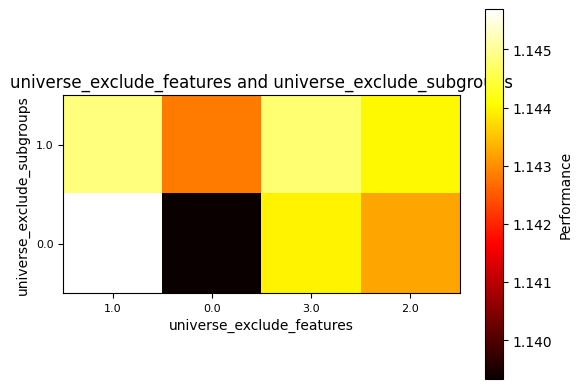

In [38]:
vis.plot_pairwise_marginal(['universe_exclude_features', 'universe_exclude_subgroups'])

## Quantify Importance with Partial Data

In [39]:
from tqdm import tqdm

PARTIAL_FANOVA_DIR = ANALYSIS_OUTPUT_DIR / "partial_fanova" / "overall"
PARTIAL_FANOVA_DIR.mkdir(parents=True, exist_ok=True)

N_ITERATIONS = 10

In [40]:
from fairness_multiverse.analysis import MultiverseFanova
import joblib

def quantify_importance_for_fraction(fraction: float, base_directory = PARTIAL_FANOVA_DIR):
    # Get random subset of the data
    df = df_agg.sample(frac = fraction).reset_index(drop = True)
    data_hash = joblib.hash(df)

    # Create directory for this fraction
    directory = base_directory / f"fraction-{fraction}"
    directory.mkdir(exist_ok = True)

    # Run FANOVA on subset
    partial_fanova = MultiverseFanova(features = df[["universe_model", "universe_exclude_features", "universe_exclude_subgroups"]], outcome = df[main_cp_metric])
    partial_fanova.quantify_importance(save_to = directory / f"partial-fanova_importance_interactions-majmin-{fraction}-{data_hash}.csv")

In [41]:
for i in tqdm(range(N_ITERATIONS)):
    quantify_importance_for_fraction(0.01)

  0%|          | 0/10 [00:00<?, ?it/s]


RuntimeError: Encountered zero total variance in all trees.

In [42]:
for i in tqdm(range(N_ITERATIONS)):
    quantify_importance_for_fraction(0.05)

100%|██████████| 10/10 [00:00<00:00, 45.27it/s]


In [43]:
for i in tqdm(range(N_ITERATIONS)):
    quantify_importance_for_fraction(0.1)

100%|██████████| 10/10 [00:00<00:00, 33.23it/s]


In [44]:
for i in tqdm(range(N_ITERATIONS)):
    quantify_importance_for_fraction(0.2)

100%|██████████| 10/10 [00:00<00:00, 24.24it/s]
